In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

# Data preparation

In [4]:
def normalize_col(col):
    avg=col.mean()
    std=col.std()
    return col.map(lambda x: (x-avg)/std)
def turn_categorical(df,cols):
    for col in cols:
        df=pd.concat([df,pd.get_dummies(df[col],prefix=col,prefix_sep='_')],axis=1).drop(col,axis=1)
    return df

In [5]:
data=pd.read_csv('data/ecommerce_data.csv')
data[['n_products_viewed','visit_duration']]=data[['n_products_viewed','visit_duration']].apply(normalize_col)
data=turn_categorical(data,['time_of_day'])
data=data[data['user_action']<=1]
data.head()

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,user_action,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3
0,1,-0.816161,-0.407869,0,0,0,0,0,1
1,1,0.139531,-0.498929,0,1,0,0,1,0
2,1,-0.816161,-1.037804,1,0,0,1,0,0
6,0,-0.816161,0.393614,1,0,0,1,0,0
7,1,-0.816161,-1.044956,0,0,0,0,0,1


In [24]:
X=data.drop('user_action',axis=1).as_matrix()
Y=data['user_action'].as_matrix()
X.shape,Y.shape

((398, 8), (398,))

# Functions

## Generic

In [63]:
def one_hot_encoder(v):
    return np.eye(v.max()+1)[v]
def softmax(v):
    expv=np.exp(v)
    if v.shape[0]>1:
        return expv/expv.sum(axis=1,keepdims=True)
    else:
        return expv/expv.sum(axis=1)
def compute_cost(T,Y):
    return -(T*np.log(Y)).mean()
def compute_accuracy(Y,P):
    return (Y==P).mean()

## Logistic regression

In [43]:
def populate_W(X,Y):
    return np.random.rand(X[0].size+1,Y.max()+1)
def forward(X,W,softmax_output=True):
    X=np.append(X,np.ones((X.shape[0],1)),1)
    if softmax_output:
        return softmax(X.dot(W))
    else:
        return X.dot(W)
def train(X,Y,num_test=100,random_state=None,
          W_0=None,
          learning_rate=10e-3,num_rounds=10000,
          report_step=10,print_every=1000,plot_cost=True):
    reports=[]
    X,Y=sklearn.utils.shuffle(X,Y,random_state=random_state)
    X_train,Y_train=X[:-num_test],Y[:-num_test]
    X_test,Y_test=X[-num_test:],Y[-num_test:]
    T_train,T_test=one_hot_encoder(Y_train),one_hot_encoder(Y_test)
    if W_0!=None:
        W=W_0
    else:
        W=populate_W(X_train,Y_train)
    for n in range(num_rounds):
        preds_train=forward(X_train,W)
        preds_test=forward(X_test,W)
        if n % report_step==0:
            cost_train=compute_cost(T_train,preds_train)
            cost_test=compute_cost(T_test,preds_test)
            if print_every and n % print_every==0:
                print("{:4d} {:0.5f} {:0.5f}".format(n,cost_train,cost_test))
            reports.append([n,cost_train,cost_test])
        X_ext=np.append(X_train,np.ones((X_train.shape[0],1)),1)
        W=W-learning_rate*X_ext.T.dot(preds_train-T_train)
    cost_train=compute_cost(T_train,preds_train)
    cost_test=compute_cost(T_test,preds_test)
    reports.append([n,cost_train,cost_test])
    print('Train: {:0.5f}, Test: {:0.5f}'.format(compute_accuracy(Y_train,np.argmax(preds_train,axis=1)),
                                                 compute_accuracy(Y_test,np.argmax(preds_test,axis=1))))
    if plot_cost:
        plt.plot([r[1] for r in reports])
        plt.plot([r[2] for r in reports])
        plt.show()
    return W,reports

   0 0.37271 0.37187
1000 0.04964 0.26008
2000 0.04964 0.26009
3000 0.04964 0.26009
4000 0.04964 0.26009
5000 0.04964 0.26009
6000 0.04964 0.26009
7000 0.04964 0.26009
8000 0.04964 0.26009
9000 0.04964 0.26009
Train: 0.98322, Test: 0.92000


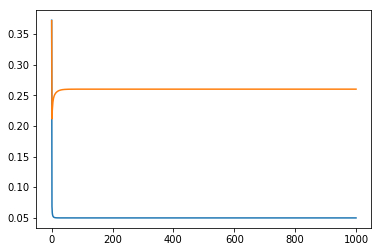

CPU times: user 1.25 s, sys: 152 ms, total: 1.4 s
Wall time: 1.24 s


In [46]:
%%time
W,report=train(X,Y,random_state=42,report_step=10,print_every=1000)

## Neural network

In [57]:
def populate_W(X,Y,net_structure):
    net_structure=[X[0].size]+net_structure+[Y.max()+1]
    W=[]
    for i in range(len(net_structure)-1):
        W.append(np.random.randn(net_structure[i]+1,net_structure[i+1]))
    return W
def process(X,W):
    X=np.append(X,np.ones((X.shape[0],1)),1)
    return X.dot(W)
def sigmoid(v):
    return 1/(1+np.exp(-v))
def forward(X,W,func=sigmoid,softmax_output=True):
    v=[X]
    for l in range(len(W)):
        v.append(func(process(v[-1],W[l])))
    if softmax_output:
        v[-1]=softmax(v[-1])
    return v
def derivate(layer,delta,W):
    next_delta=delta.dot(W[:-1,:].T)*layer*(1-layer)
    layer=np.append(layer,np.ones((layer.shape[0],1)),1)
    return layer.T.dot(delta),next_delta
def train(X,Y,net_structure,W_0=None,
          num_test=100,random_state=None,
          learning_rate=10e-7,num_rounds=100000,
          report_step=100,print_every=5000,plot_cost=True):
    reports=[]
    X,Y=sklearn.utils.shuffle(X,Y,random_state=random_state)
    X_train,Y_train=X[:-num_test],Y[:-num_test]
    X_test,Y_test=X[-num_test:],Y[-num_test:]
    T_train,T_test=one_hot_encoder(Y_train),one_hot_encoder(Y_test)
    if W_0!=None:
        W=W_0
    else:
        W=populate_W(X_train,Y_train,net_structure)
    for n in range(num_rounds):
        preds_train,preds_test=forward(X_train,W),forward(X_test,W)
        if n % report_step==0:
            cost_train,cost_test=compute_cost(T_train,preds_train[-1]),compute_cost(T_test,preds_test[-1])
            if print_every and n % print_every==0:
                print("{:5d} {:0.5f} {:0.5f}".format(n,cost_train,cost_test))
            reports.append([n,cost_train,cost_test])
        delta=preds_train[-1]-T_train
        for l in reversed(range(len(W))):
            gradient,new_delta=derivate(preds_train[l],delta,W[l])
            delta=new_delta
            W[l]=W[l]-learning_rate*gradient
    cost_train,cost_test=compute_cost(T_train,preds_train[-1]),compute_cost(T_test,preds_test[-1])
    reports.append([num_rounds,cost_train,cost_test])
    print('Train: {:0.5f}, Test: {:0.5f}'.format(compute_accuracy(Y_train,np.argmax(preds_train[-1],axis=1)),
                                                 compute_accuracy(Y_test,np.argmax(preds_test[-1],axis=1))))
    if plot_cost:
        plt.plot([r[1] for r in reports])
        plt.plot([r[2] for r in reports])
        plt.show()
    return W,reports

    0 0.37098 0.36861
10000 0.19894 0.22740
20000 0.16529 0.19681
30000 0.16502 0.19663
40000 0.16274 0.19663
50000 0.16188 0.19663
60000 0.16188 0.19663
70000 0.16221 0.19663
80000 0.16258 0.19663
90000 0.16141 0.19168
Train: 0.98993, Test: 0.93000


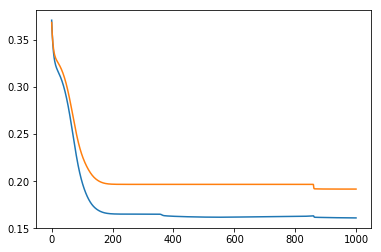

CPU times: user 57.3 s, sys: 140 ms, total: 57.4 s
Wall time: 57.3 s


In [62]:
%%time
W,report=train(X,Y,net_structure=[8,8],learning_rate=10e-6,random_state=42,report_step=100,print_every=10000)